In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n-project/daniel/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n-project/daniel


In [ ]:
import numpy as np 
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm.notebook as tq
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn')
plt.rc('axes', labelsize=17)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
NUM_TRAIN = 1250
NUM_TEST = 250
C = 5

def load_dataset():
  X_train = np.load('./datasets/X_ImageNet_8x8_5c_train.npy')    # (6500, 8, 8)
  y_train = np.load('./datasets/y_ImageNet_8x8_5c_train.npy')    # (650, )
  X_test = np.load('./datasets/X_ImageNet_8x8_5c_test.npy')    # (250, 8, 8)
  y_test = np.load('./datasets/y_ImageNet_8x8_5c_test.npy')    # (250, )

  # Normalize
  mean, std = X_train.mean(), X_train.std()
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std

  X_train = X_train[:NUM_TRAIN]
  y_train = y_train[:NUM_TRAIN]
  X_test = X_test[:NUM_TEST]
  y_test = y_test[:NUM_TEST]

  y_train -= 1      # y labels are numered from 1, we want them from zero
  y_test -= 1      # y labels are numered from 1, we want them from zero
  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_train.shape: {y_test.shape}')

X_train.shape: (1250, 8, 8), y_train.shape: (1250,)
X_test.shape: (250, 8, 8), y_train.shape: (250,)


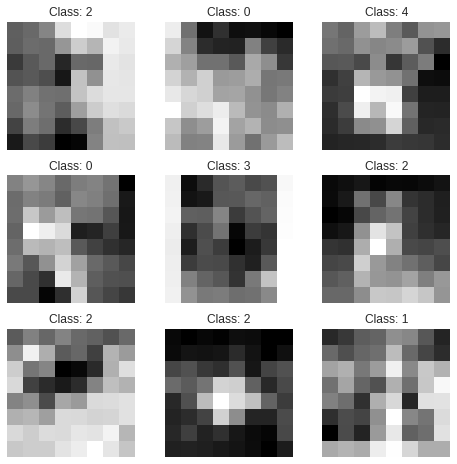

In [186]:
def visualize_dataset(X, y):
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(X))
    img, label = X[sample_idx], y[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
  plt.show()

visualize_dataset(X_train, y_train)

In [187]:
class Convex_FC_Solver():
    def __init__(self, num_classes, beta, max_iters):
        self.a, self.b, self.c = 0.09, 0.5, 0.47
        self.C = num_classes
        self.beta = beta
        self.max_iters = max_iters

        self.D = None # will be set by solver

        # Solutions
        self.Z, self.Z_prime, self.Z_V = None, None, None
        self.Z4, self.Z4_prime = None, None

    def compute_X_V(self, X):
        '''
        @param X: shape (N, D)
        @returns: X_V (X vectorized) a (N, D**2+D+1) matrix
        '''
        a, b, c = self.a, self.b, self.c
        N, D = X.shape
        X_V = np.zeros((N, D**2+D+1))
        for i in range(N):
            x_i = X[i:i+1, :].T
            X_V[i, 0:D**2] = a*(x_i @ x_i.T).reshape(D**2)
            X_V[i, D**2:D**2+D] = b*x_i.reshape(D)
            X_V[i, D**2+D] = c*1
        return X_V

    @staticmethod
    def flatten(X):
        return X.reshape((X.shape[0], -1))

    def get_Y_expanded(self, y):
        '''
        @param y: (N,)
        @return Y: (N, C) such that
        Y[i, j] = 1 if y[i] == j else 0
        '''
        N, C = y.shape[0], self.C
        Y = np.zeros((N, C))
        Y[range(N), y] = 1
        return Y

    def compute_Z(self):
        C, D = self.C, self.D
        Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime = [], [], [], [], [], []
        Z, Z_prime = [], []

        for k in range(C):
            Z1.append(cp.Variable((D, D), symmetric=True))
            Z2.append(cp.Variable((D, 1)))
            Z4.append(cp.Variable((1, 1)))

            Z1_prime.append(cp.Variable((D, D), symmetric=True))
            Z2_prime.append(cp.Variable((D, 1)))
            Z4_prime.append(cp.Variable((1, 1)))

            Z.append(cp.vstack([
                cp.hstack((Z1[k], Z2[k])),
                cp.hstack((Z2[k].T, Z4[k]))])) # (D+1, D+1)

            Z_prime.append(cp.vstack([
                cp.hstack((Z1_prime[k], Z2_prime[k])),
                cp.hstack((Z2_prime[k].T, Z4_prime[k]))])) # (D+1, D+1)

        Z_V = cp.hstack([cp.vstack([
            cp.reshape((Z1[k]-Z1_prime[k]), (D**2, 1)),
            (Z2[k]-Z2_prime[k]),
            (Z4[k]-Z4_prime[k])
        ]) for k in range(C)]) # (D**2+D+1, C)

        return Z_V, Z, Z_prime, Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime


    def solve(self, X, y, verbose=False):
        '''
        X -> (N, *Dims)
        Y -> (N)
        '''
        X = self.flatten(X)
        N, D = X.shape
        C = self.C
        self.D = D

        Y = self.get_Y_expanded(y)
        X_V = self.compute_X_V(X)
        Z_V, Z, Z_prime, Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime = self.compute_Z()

        Y_hat = X_V @ Z_V

        if verbose:
          print(f'X.shape = {X.shape}') # (N, D)
          print(f'Y.shape = {Y.shape}')  # (N, C)
          print(f'X_V.shape = {X_V.shape}')  # (N, D**2+D+1)
          print(f'Z_V.shape = {Z_V.shape}')  # (D**2+D+1, C)

        loss = 0.5 * cp.sum_squares(Y - Y_hat) + self.beta * cp.sum(Z4 + Z4_prime)
        objective = cp.Minimize(loss)

        constraints = []
        for k in range(C):
            constraints += [
                Z[k] >> 0,
                Z_prime[k] >> 0,
                cp.trace(Z1[k]) == Z4[k],
                cp.trace(Z1_prime[k]) == Z4_prime[k],
            ]

        problem = cp.Problem(objective, constraints)
        print(f'##########')
        print('Started...')
        start = time()
        problem.solve(max_iters=self.max_iters, verbose=verbose)
        end = time()
        print(f'Finished, time: {end-start}')
        print(f'status: {problem.status}')
        print(f'optimal value: {objective.value}')
        print('##########')

        # Save solution
        self.Z_V = Z_V.value
        self.Z, self.Z_prime = self.values(Z), self.values(Z_prime)
        self.Z4, self.Z4_prime = self.values(Z4), self.values(Z4_prime)

        return None

    def values(self, arr):
        return [arr[k].value for k in range(len(arr))]

    def predict(self, X):
        X = flatten(X)
        X_V = self.compute_X_V(X)
        Z_V = self.Z_V
        Y_hat = X_V @ Z_V
        return Y_hat

    def calculate_loss(self, Y_hat, y):
        Y = self.get_Y_expanded(y)
        loss = 0.5 * np.sum((Y - Y_hat)**2) + self.beta * np.sum(self.Z4 + self.Z4_prime)
        return loss

    def get_num_neurons(self, tolerance: float):
        count = 0
        C = self.C
        Z, Z_prime = self.Z, self.Z_prime
        for c in range(C):
            eigvals1, _ = np.linalg.eig(Z[c])
            eigvals2, _ = np.linalg.eig(Z_prime[c])
            count += np.sum(eigvals1 > tolerance) + np.sum(eigvals2 > tolerance)
        return count

In [202]:
# Note 1: beta = 0 finishes fast, for beta > 0 it takes very long to reach optimal value
# so use verbose=True and max_iters to determine when to stop
solver = Convex_FC_Solver(num_classes=C, beta=1, max_iters=500)
solver.solve(X_train, y_train, verbose=True)

X.shape = (1250, 64)
Y.shape = (1250, 5)
X_V.shape = (1250, 4161)
Z_V.shape = (4161, 5)
##########
Started...
----------------------------------------------------------------------------
	SCS v2.1.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 26834602
eps = 1.00e-04, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 21451, constraints m = 27712
Cones:	primal zero / dual free vars: 10
	soc vars: 6252, soc blks: 1
	sd vars: 21450, sd blks: 10
Setup time: 1.11e+02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.96e+20  2.40e+20  1.00e+00 -1.31e+22  9.96e+21  1.79e+22  8.11e-01 
   100| 1.69

In [203]:
scores = solver.predict(X_train)
y_pred = np.argmax(scores, axis=1)
train_accuracy = np.sum(y_train == y_pred) / y_train.shape[0]
print(f'train_accuracy: {train_accuracy}')
print(f'loss: {solver.calculate_loss(scores, y_train)}')

train_accuracy: 0.9456
loss: 242.05955627041766


In [204]:
scores = solver.predict(X_test)
y_pred = np.argmax(scores, axis=1)
test_accuracy = np.sum(y_test == y_pred) / y_test.shape[0]
print(f'test_accuracy: {test_accuracy}')
print(f'loss: {solver.calculate_loss(scores, y_test)}')

test_accuracy: 0.28
loss: 265.38078928331953


In [191]:
print(f'num_neurons: {solver.get_num_neurons(tolerance=10**(-6))}')

num_neurons: 434


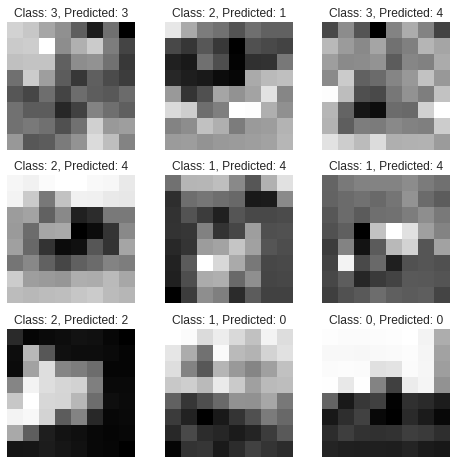

In [192]:
def visualize_predictions(X, y, y_pred):
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(X))
    img, label, pred_label = X[sample_idx], y[sample_idx], y_pred[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}, Predicted: {pred_label}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
  plt.show()

visualize_predictions(X_test, y_test, y_pred)